### **Model-2: Pose Estimation**

Model-2 is responsible for extracting precise body landmarks needed for garment alignment in the virtual try-on pipeline. Correctly estimating the orientation of shoulders, arms, torso curvature, and head position is essential for accurate garment warping and subsequent try-on generation.

**Input:**
A single-person RGB image.

**Outputs:**

* 33 anatomical landmarks
* Skeleton visualization
* Landmark confidence scores

These outputs are used directly by the Geometric Matching Module (GMM) and the Try-On Generator (Model-3).

---

### **Why MediaPipe Pose?**

MediaPipe Pose is selected for its efficiency, lightweight execution, and high stability on single-person images. It provides a full set of 33 landmarks with consistent indexing and confidence metrics, making it ideal for downstream alignment tasks.

---

### **Output Requirements**

For each processed image, two outputs are generated:

1. **Landmark JSON file**
   Structure example:

   ```json
   {
     "nose": [x, y, confidence],
     "left_shoulder": [x, y, confidence],
     "right_shoulder": [x, y, confidence],
     "left_elbow": [x, y, confidence]
   }
   ```

2. **Skeleton image**
   A rendered visualization connecting all detected landmarks.

These artifacts form the standard pose representation consumed by GMM and Model-3.

---

### **Implementation Plan**

#### **Step 1 – Pose Pipeline Script**

A `pipeline.py` script will be created under:

```
backend/pose/
```

The script will:

* Load MediaPipe Pose
* Accept a person image as input
* Detect all 33 landmarks
* Convert landmarks into the standardized format
* Save both JSON and skeleton visualization files

#### **Step 2 – Integration Format**

The stored outputs will follow consistent naming and structure, enabling direct integration with the warping and try-on models without preprocessing overhead.


## Imports

In [1]:
import mediapipe as mp
import cv2
import numpy as np

In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [3]:
# For an image:
image = cv2.imread('D:/Code Playground/wardrob-aI/data/my_photos/person_02.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)

### **Pose Landmark Extraction**

This code processes the output of MediaPipe Pose and extracts all 33 body landmarks detected from an input image. Each landmark contains normalized coordinates (`x`, `y`, `z`) and a visibility confidence score. The script stores these landmarks in two formats:

1. **Normalized coordinates** (0–1 range) for JSON export and model input.
2. **Pixel coordinates** (scaled to actual image width and height) for skeleton drawing and visualization.

Together, these representations provide the spatial information required for garment alignment in the virtual try-on pipeline.

In [4]:
if results.pose_landmarks:
    # Access individual landmarks
    nose = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]

    # Extract all landmarks into a list or array
    landmarks_list = []
    for landmark in results.pose_landmarks.landmark:
        landmarks_list.append({
            'x': landmark.x,
            'y': landmark.y,
            'z': landmark.z,
            'visibility': landmark.visibility
        })
        
    # Convert normalized coordinates to pixel coordinates (if needed)
    image_height, image_width, _ = image.shape # or frame.shape
    pixel_landmarks = []
    for landmark in results.pose_landmarks.landmark:
        pixel_landmarks.append({
            'x': int(landmark.x * image_width),
            'y': int(landmark.y * image_height),
            'z': landmark.z, # Z coordinate is not scaled to image dimensions
            'visibility': landmark.visibility
        })

In [5]:
pixel_landmarks[:5]

[{'x': 365,
  'y': 264,
  'z': -0.7674870491027832,
  'visibility': 0.9999990463256836},
 {'x': 377,
  'y': 247,
  'z': -0.7366158962249756,
  'visibility': 0.9999982118606567},
 {'x': 384,
  'y': 247,
  'z': -0.7367358803749084,
  'visibility': 0.9999984502792358},
 {'x': 389,
  'y': 248,
  'z': -0.7368132472038269,
  'visibility': 0.9999982118606567},
 {'x': 356,
  'y': 247,
  'z': -0.7231107354164124,
  'visibility': 0.9999977350234985}]

## View the Original image and skeleton image

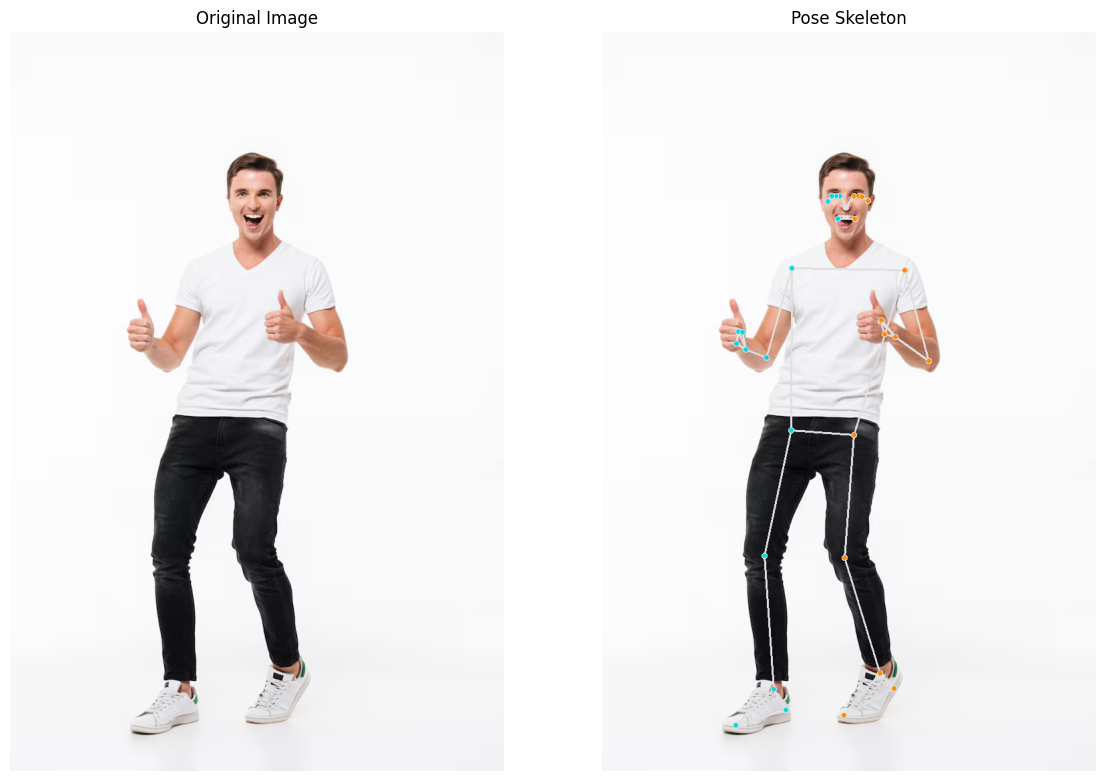

In [6]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

def show_original_and_skeleton(image, results, mp_pose):
    """
    Display the original image and the skeleton overlay side-by-side.
    """

    # ----- ORIGINAL IMAGE -----
    img_original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ----- SKELETON IMAGE -----
    img_skeleton = image.copy()

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    mp_drawing.draw_landmarks(
        img_skeleton,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
    )

    img_skeleton = cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB)

    # ----- DISPLAY BOTH -----
    plt.figure(figsize=(14, 10))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.title("Original Image")
    plt.axis("off")

    # Skeleton
    plt.subplot(1, 2, 2)
    plt.imshow(img_skeleton)
    plt.title("Pose Skeleton")
    plt.axis("off")

    plt.show()
show_original_and_skeleton(image, results, mp_pose)


## Saving the Pixel landmark joints as JSON

In [7]:
import json
import os

def save_pose_json(pixel_landmarks, image_width, image_height, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    data = {
        "landmarks": pixel_landmarks,
        "num_points": len(pixel_landmarks),
        "image_size": [image_height, image_width]
    }

    with open(save_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Pose JSON saved to: {save_path}")

In [8]:
save_pose_json(pixel_landmarks, image_height, image_width, save_path = "D:/Code Playground/wardrob-aI/experiments/output/pose_estimation/pose_keypoints.json")

Pose JSON saved to: D:/Code Playground/wardrob-aI/experiments/output/pose_estimation/pose_keypoints.json
